# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
brain

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

In [8]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [9]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, init_std =0.4):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.init_std = init_std
        self.training = True ## set this to false in the act method after the training is over

        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        ## Adding noise to weight that will not be trained
        self.register_buffer('weight_epsilon',torch.FloatTensor(out_features, in_features) )

        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        ## Adding noise to bias that will not be trained
        self.register_buffer('bias_epsilon',torch.FloatTensor(out_features) )   

        self.reset_parameter()  ##reset mu and sigma
        self.reset_noise()      ##reset epsilon
    
    def forward(self,X):
        if self.training:
            weight = self.weight_mu + self.weight_sigma.mul(Variable(self.weight_epsilon))
            bias = self.bias_mu + self.bias_sigma.mul(Variable(self.bias_epsilon))
        else:
            weight = self.weight_mu + self.weight_sigma
            bias = self.bias_mu + self.bias_sigma

        return F.linear(X, weight, bias)
  
    def reset_parameter(self):
        '''
        Initialize mu and sigma for weight and bias
        '''
        mu_range = 1/math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.bias_mu.data.uniform_(-mu_range, mu_range)

        self.weight_sigma.data.fill_(self.init_std*mu_range)
        self.bias_sigma.data.fill_(self.init_std*mu_range)
    
    def reset_noise(self):
        '''
        Generate noise for epsilon.
        These noise weights are not trainable by the model
        '''
        epsilon_out  = self.scale_noise(self.out_features)
        epsilon_in   = self.scale_noise(self.in_features)

        ##.ger() gives the matrix out of 2 vector numtiplication
        ## epsilon_out is out*1 
        ## epsilon_in is in*1
        ## the out of .ger() is out*in
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))

        ## dont use the same random value for bias.
        ## call scale_coise once again for bias
        self.bias_epsilon.copy_(self.scale_noise(self.out_features))
    
    
    def scale_noise(self, size):
        '''
        Gives the noise output of a particular size after scaling
        '''


        X = torch.randn(size)
        X = X.sign().mul(X.abs().sqrt())
        return X

In [11]:
##Network


class QNetwork(nn.Module):
    """Network Model."""
    def __init__(self, state_size, action_size, seed,fc1_size =64, fc2_size=128):
    ##def __init__(self, state_size, action_size, seed,fc1_size =256, fc2_size=512):
        '''
        Initialize Parameters
        '''
        super(QNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.seed = torch.manual_seed(seed)
        self.FC1_size = fc1_size
        self.FC2_size = fc2_size
        self.FC1 = nn.Linear(self.state_size, self.FC1_size)
        self.FC2 = nn.Linear(self.FC1_size, self.FC2_size)
        ##Kaustav
        ##self.FC3 = nn.Linear(self.FC2_size, self.FC2_size*2)
        ##Kaustav
        
        #self.FC2 = nn.Linear(self.FC1_size, self.FC2_size)
        #self.FC3 = nn.Linear(self.FC2_size, self.action_size)

        #self.noisy1 = NoisyLinear(self.FC1_size,self.FC2_size)
        #self.noisy2 = NoisyLinear(self.FC2_size,action_size)


        ##Noisy DQN and Dueling DQN
        self.noisy_advantage1 =     NoisyLinear(self.FC2_size,self.FC2_size)
        self.noisy_advantage2 =     NoisyLinear(self.FC2_size,action_size)
        ##Noisy DQN and Dueling DQN
        self.noisy_value1 =     NoisyLinear(self.FC2_size,self.FC2_size)
        self.noisy_value2 =     NoisyLinear(self.FC2_size,1)
                               
    
  
    def forward(self, state):
        """
        Build a network that maps state -> action values.
        """
        #x = F.relu(self.FC1(state))
        #x = F.relu(self.noisy1(x))
        #x = self.noisy2(x)

        x = F.relu(self.FC1(state))
        x = F.relu(self.FC2(x))
        ##x = F.relu(self.FC3(x))

        #advantage
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(x)
        #value
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(x)

        ##Dueling DQN
        x = value + advantage - advantage.mean()

        return x

    def reset_noise(self):
    
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()

        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()

In [12]:
import numpy as np
import random
from collections import namedtuple, deque

import torch.optim as optim

##HYPERPARAMETERS

BUFFER_SIZE = int(1e5)  ##replay buffer size
BATCH_SIZE  = 128       ##minibatch size
GAMMA  = .99            ##discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
##LR = 1e-4  
#LR = 1e-5  

UPDATE_EVERY = 4        ## how often local network gets copied to target network

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [13]:
## Define the Replay Buffer ( Deque)

class ReplayBuffer:
    """
    Fixed-size buffer to store experience tuples.
    """
    def __init__(self,action_size, buffer_size, batch_size, seed):
        self.seed = random.seed(seed)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.action_size = action_size


        self.experience = namedtuple("Experience", field_names =["state", "actions","rewards","next_state", "done"])
        self.memory = deque(maxlen= buffer_size)
    
    def add(self, state, action,rewards, next_state, done):

        experience = self.experience(state, action,rewards,next_state, done)
        self.memory.append(experience)
      
    def sample(self):
        '''
        Randomly sample a batch from experience
        '''

        experiences = random.sample(self.memory,k = self.batch_size)

        state = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.actions for e in experiences if e is not None])).long().to(device)  ## dont change to float
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)
        next_state = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        done = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)

        return state,actions, rewards, next_state, done
    def __len__(self):
        """
        Return the current size of internal memory.
        """
        return len(self.memory)
  

    


In [14]:
## Define the Agent

class Agent():
    '''
    Interacts with and learns from the environment.
    '''
    def __init__(self,state_size,action_size, seed,batch_size= BATCH_SIZE,buffer_size= BUFFER_SIZE,lr=LR , gamma= GAMMA ):

        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.lr = lr
        self.gamma = gamma

        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local =  QNetwork(self.state_size, self.action_size, seed).to(device)
        self.qnetwork_target = QNetwork(self.state_size , self.action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr= self.lr)
        self.criterion = nn.MSELoss()
        
        for param in self.qnetwork_target.parameters():
            param.requires_grad = False

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
  
  
    def step(self,state,actions,rewards, next_state,done):
        self.memory.add(state,actions,rewards, next_state,done)
        self.t_step =(self.t_step + 1)% UPDATE_EVERY
        ## dont learn whenever 1 batch is added.
        ##Rather wait for UPDATE_EVERY batch to be added before we call learn once
        if self.t_step==0:
            if len(self.memory)> self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
    
    def learn(self,experiences, gamma):
        """
        Update value parameters using given batch of experience tuples.
        """
        state, actions, rewards,next_state, done = experiences 
        #target_q = self.qnetwork_target(next_state).detach()
        #target_values = rewards + gamma*torch.max(target_q, 1)[0].unsqueeze(1)*(1-done)
        #current_values= self.qnetwork_local(state).gather(1, actions)

        #Double DQN
        current_values= self.qnetwork_local(state).gather(1, actions)
        target_q = self.qnetwork_local(next_state)
        target_q = torch.max(target_q, 1)[1].unsqueeze(1)
        target_values = rewards + gamma*self.qnetwork_target(next_state).gather(1, target_q)*(1-done)


        # Compute loss
        loss = self.criterion(current_values,target_values)


        ##optimization step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ----- Update the target network -----
        if self.t_step==0:
          ## when it comes here self.t_step will always be 0 anyways. 
          ## So you may remove this if condition
            self.soft_update(self.qnetwork_local, self.qnetwork_target,TAU)

        ##Noisy DQN
        self.qnetwork_local.reset_noise()
        self.qnetwork_target.reset_noise()
    
    def soft_update(self, qnetwork_local, qnetwork_target,tau):
        '''
        Update the target Q Network
        '''
        for local_parms, target_parms in zip(qnetwork_local.parameters(), qnetwork_target.parameters()):
            target_parms.data.copy_(tau*local_parms.data + (1.0 -tau)*target_parms.data)
        
        
    def act(self, state, epsilon =0.0):

        """
        Returns actions for given state as per current policy.
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.qnetwork_local.eval()
        with torch.no_grad():
            actions_values = self.qnetwork_local(state)

        ##Back to train mode
        self.qnetwork_local.train()

        # Epsilon-greedy action selection

        if random.random() > epsilon:
            return np.argmax(actions_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.action_size))
      
    

In [15]:
def dqn(n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_end = .01, eps_decay= .995,
        beta_start=0.4,beta_frames= 1000, trained_score=16):
    '''
    Train the network
    Please ignore beta_start and beta_frames parameters as of now
    '''
    scores =[]
    scores_window = deque(maxlen = 100)
    eps = eps_start
    for episode in range(1,n_episodes+1):
        #print(episode)
        score = 0
        ##beta= min(1.0, beta_start  + episode*(1- beta_start)/beta_frames )
        ##reset the environment
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0] 
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            rewards = env_info.rewards[0]
            #done = env_info.local_done[0]
            #convert done from bool to float
            #
            if env_info.local_done[0]:
                done =1
            else:
                done =0
            ##agent.step(state, action,rewards,next_state ,  done,beta )
            agent.step(state, action,rewards,next_state ,  done )
            state = next_state
            
            score += rewards
            if  done:
                break

        scores.append(score)
        scores_window.append(score)
        eps = max(eps_end, eps*eps_decay)  ## reduce randomness epsilon as we learn
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        ##if np.mean(scores_window)>=200.0:
        if np.mean(scores_window)>=trained_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

Episode 100	Average Score: 0.03
Episode 200	Average Score: 2.61
Episode 300	Average Score: 6.56
Episode 400	Average Score: 8.59
Episode 500	Average Score: 11.31
Episode 600	Average Score: 12.73
Episode 700	Average Score: 13.28
Episode 800	Average Score: 15.21
Episode 900	Average Score: 14.55
Episode 1000	Average Score: 14.96
Episode 1100	Average Score: 16.00

Environment solved in 1000 episodes!	Average Score: 16.00


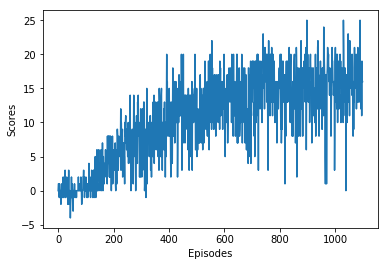

In [16]:
env_observation_space = 37
env_action_space = 4

agent = Agent(env_observation_space ,env_action_space, seed=0 )
scores = dqn()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)) , scores)

plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()